# Completeness of the Gaia DR2 open cluster census

This notebook provides a complementary analysis for the Cluster Age Function analysis of the Gaia DR2 Open Custer census performed in the Appendix of [this A&A Letter](https://ui.adsabs.harvard.edu/abs/2020arXiv200601690A/abstract). In particular, we characterise the completeness of the [Cantat-Gaudin+2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200407274C/abstract) catalogue of Galactic open clusters.

We make the following approximation:

\begin{align}
p({\it Gaia}\, {\rm DR2\ cluster\, has\, CG2020\, parameters}) &= p({\it Gaia}\, {\rm DR2\, detection}) \cdot p({\rm ANN\ converged} | {\it Gaia}\, {\rm DR2\, detection}) \\
&\approx p({\it Gaia}\, {\rm DR2\, detection} | l, b, d, \log t, A_V) \cdot p({\rm ANN\ converged} | d, \log t)\\
&\approx {\rm completeness\ of\ CastroGinard2020} \cdot {\rm completeness\ of\ CantatGaudin2020\ ANN}
\end{align} 

In other words, the completeness of the age census of Gaia DR2 OCs depends on 1. our detection efficiency and 2. on our ability to derive OC parameters once we know that there is a cluster. 

The implicit assumptions in this approximation are:
* The Gaia DR2 clusters contained in [Cantat-Gaudin+2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200407274C/abstract) are all true physical OCs. Due to the exquisite astrometric quality of Gaia and the conservative requirements of CG+2020, this is probably a good assumption.
* The experiment of [Castro-Ginard+2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...635A..45C/abstract) is representative for the full catalogue. This is hard to estimate, but the best we can do at present: On the one hand, this estimate is pessimistic, because we only estimate the completeness of 1 method (DBSCAN), while the full catalogue of Gaia-detected OCs was compiled from various different search methods (traditional OCs, serendipitous discoveries, FoF search, etc.). It is also pessimistic in the sense that the method has added more than 500 new OCs! On the other hand, one might say that the DBSCAN completeness test of [Castro-Ginard+2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...635A..45C/abstract) was slightly optimistic, since it only used the catalogue of [Cantat-Gaudin et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...618A..93C/abstract) as an input, and not the most compilation of Gaia DR2-detected OCs. In summary, it is the best we can do at present.

## I. Analysing the completeness of Castro-Ginard et al. (2020) clusters

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pylab as plt
import os.path
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from astropy.table import Table, Column, MaskedColumn
import astropy.table
import matplotlib
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from scipy.stats import gaussian_kde
from scipy import interpolate

import abj2016

Load list of Gaia DR2 clusters as of April 2020 (Cantat-Gaudin et al. 2020):

In [2]:
nntable = Table.read("./data/Table1_CDS.fits")
nntable["oc"] = [np.char.strip(a, ' ') for a in nntable["oc"]]

[Castro-Ginard+2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...635A..45C/abstract) investigated the recovery fraction of their catalogue by comparing their blind-search candidates obtained with DBSCAN to the OC list of [Cantat-Gaudin et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...618A..93C/abstract). They categorise these clusters into recovered/half-recovered/non-recovered - see [Fig. 1 of Castro-Ginard et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...635A..45C/graphics).

Here we read the output data of this test and join them into a table:

In [3]:
fail = np.load("./data/clustering_no.npy")
half = np.load("./data/clustering_yes_ANN_no.npy")
good = np.load("./data/clustering_yes_ANN_yes.npy")
print(len(fail), "not found;", len(half), "found but rejected;", len(good), "found & okay.")
print(len(fail) + len(half) + len(good), "in total")

alfred = Table([np.hstack([fail, half, good]), 
                np.hstack([np.zeros(len(fail)), .5*np.ones(len(half)), np.ones(len(good))])],
                names=("oc", "foundness"), )

265 not found; 276 found but rejected; 688 found & okay.
1229 in total


Join both tables:

In [4]:
joint = astropy.table.join(alfred, nntable)
joint.filled()

oc,foundness,ra,dec,l,b,r50,nbstars07,pmra,sigpmra,pmdec,sigpmdec,par,sigpar,flag,ageNN,avNN,dmNN,dist,X,Y,Z,Rgc
str17,float64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,bytes14,float32,float32,float32,int16,int16,int16,int16,int16
ASCC_10,1.0,51.87,34.981,155.723,-17.77,0.558,65,-1.737,0.159,-1.368,0.143,1.459,0.1,NN,8.42,0.63,9.1,660,-573,258,-201,8917
ASCC_101,1.0,288.399,36.369,68.028,11.608,0.372,69,0.934,0.205,1.288,0.258,2.488,0.057,NN,8.69,0.19,8.08,412,151,374,83,8197
ASCC_105,0.0,295.548,27.366,62.825,2.063,0.648,113,1.464,0.162,-1.635,0.145,1.783,0.065,NN,7.87,0.41,8.77,567,259,504,20,8096
ASCC_107,1.0,297.164,21.987,58.904,-1.901,0.174,57,-0.155,0.101,-5.156,0.115,1.109,0.049,NN,7.23,1.69,9.7,870,449,744,-28,7925
ASCC_108,1.0,298.306,39.349,74.378,6.074,0.537,188,-0.519,0.099,-1.69,0.129,0.838,0.048,NN,8.03,0.34,10.32,1160,310,1110,122,8105
ASCC_11,1.0,53.056,44.856,150.546,-9.224,0.312,245,0.926,0.163,-3.03,0.147,1.141,0.061,NN,8.39,0.6,9.69,867,-745,421,-139,9095
ASCC_110,1.0,300.742,33.528,70.411,1.378,0.203,65,0.271,0.064,-3.132,0.05,0.497,0.036,NN,8.9,0.75,11.47,1971,660,1856,47,7900
ASCC_111,0.0,302.891,37.515,74.714,2.056,0.537,136,-1.15,0.151,-1.524,0.154,1.166,0.059,NN,8.44,0.39,9.65,851,224,820,30,8157
ASCC_113,1.0,317.933,38.638,82.877,-6.589,0.529,175,0.8,0.125,-3.679,0.163,1.762,0.041,NN,8.46,0.13,8.75,563,69,555,-64,8289


Plot some projections highlighting the recovery rate of the Castro-Ginard et al. (2020) method (similar to their Fig. 1 that showed this distribution as a function of $l$ and $b$):

<IPython.core.display.Javascript object>


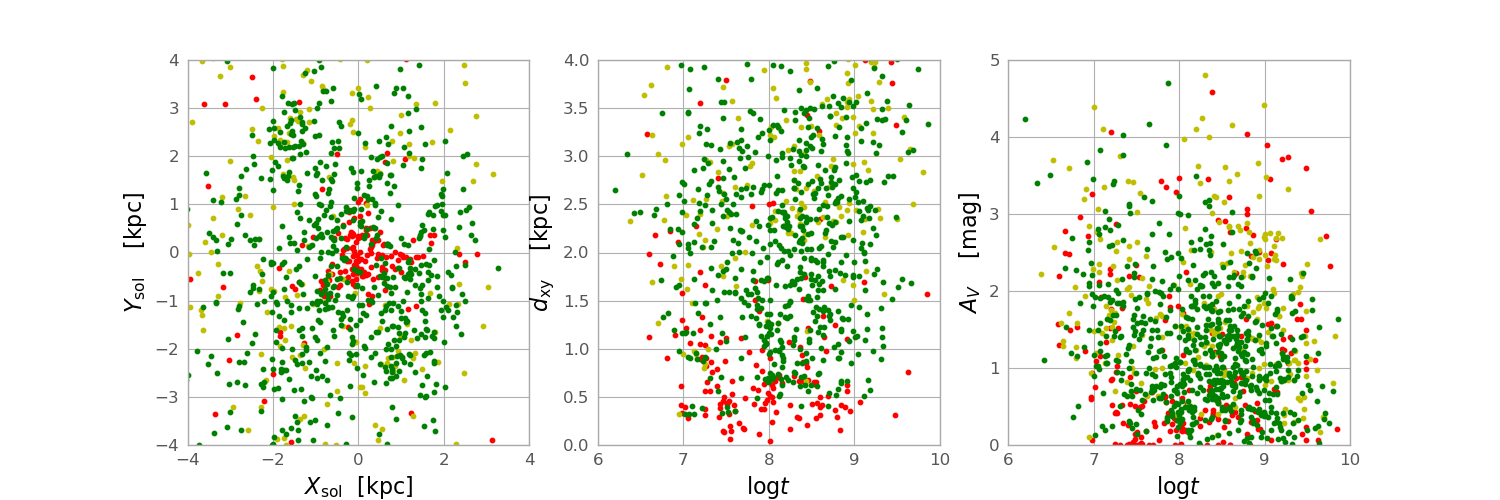

/home/friedel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
/home/friedel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/home/friedel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
/home/friedel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


In [5]:
fig = plt.figure(figsize=(15.0, 5.0))
ax  = plt.subplot(131)

mask0 = (joint["foundness"]==0.0)
mask1 = (joint["foundness"]==0.5)
mask2 = (joint["foundness"]==1.)
s=10

plt.scatter(joint[mask0]["X"]/1000., joint[mask0]["Y"]/1000., c="r", s=s)
plt.scatter(joint[mask1]["X"]/1000., joint[mask1]["Y"]/1000., c="y", s=s)
plt.scatter(joint[mask2]["X"]/1000., joint[mask2]["Y"]/1000., c="g", s=s)
plt.axis([-4,4,-4,4])
ax.set_xlabel(r"$X_{\rm sol}$  [kpc]", fontsize=16)
ax.set_ylabel(r"$Y_{\rm sol}$    [kpc]", fontsize=16)

ax  = plt.subplot(132)
joint["dxy"] = np.sqrt(joint["X"]**2.+joint["Y"]**2.)/1000.

plt.scatter(joint[mask0]["ageNN"], np.sqrt(joint[mask0]["X"]**2.+joint[mask0]["Y"]**2.)/1000., c="r", s=s)
plt.scatter(joint[mask1]["ageNN"], np.sqrt(joint[mask1]["X"]**2.+joint[mask1]["Y"]**2.)/1000., c="y", s=s)
plt.scatter(joint[mask2]["ageNN"], np.sqrt(joint[mask2]["X"]**2.+joint[mask2]["Y"]**2.)/1000., c="g", s=s)
plt.axis([6,10,0,4])
ax.set_xlabel(r"$\log t$", fontsize=16)
ax.set_ylabel(r"$d_{\rm xy}$    [kpc]", fontsize=16)

ax  = plt.subplot(133)
plt.scatter(joint[mask0]["ageNN"], joint[mask0]["avNN"], c="r", s=s)
plt.scatter(joint[mask1]["ageNN"], joint[mask1]["avNN"], c="y", s=s)
plt.scatter(joint[mask2]["ageNN"], joint[mask2]["avNN"], c="g", s=s)
plt.axis([6,10,0,5])
ax.set_xlabel(r"$\log t$", fontsize=16)
ax.set_ylabel(r"$A_V$    [mag]", fontsize=16)

plt.savefig("./im/combinedmap_clusters_recovered_4kpc.png")

### Putting it together

We see that the recovery rate does not depend significantly on $A_V$ (beyond the intrinsic correlation of this parameter with distance). Can we get the selection fraction in bins of [$l, b, d_{xy}, \log t$] ?

Yes: we just count the recovered, half-recovered, and not recovered clusters in wide bins of these parameters:

In [6]:
lgrid = np.linspace(0, 360, 5)
bgrid = np.linspace(-20,20, 3)
tgrid = np.linspace(6,10, 5)
dgrid = np.linspace(0.5,3,6)

generalmask = (joint["dxy"] > dgrid[0]) * (joint["dxy"] < dgrid[-1]) 

selfunc = np.zeros((len(lgrid) - 1, len(bgrid) - 1, len(tgrid) - 1, len(dgrid) - 1))
numstars= np.zeros((len(lgrid) - 1, len(bgrid) - 1, len(tgrid) - 1, len(dgrid) - 1))
sumstars= np.zeros((len(lgrid) - 1, len(bgrid) - 1, len(tgrid) - 1, len(dgrid) - 1))

for ii in np.arange(len(lgrid) - 1):
    for jj in np.arange(len(bgrid) - 1):
        for kk in np.arange(len(tgrid) - 1):
            for ll in np.arange(len(dgrid) - 1):
                mask = ( joint["l"] > lgrid[ii] ) & ( joint["l"] < lgrid[ii+1] ) & \
                       ( joint["b"] > bgrid[jj] ) & ( joint["b"] < bgrid[jj+1] ) & \
                       ( joint["ageNN"] > tgrid[kk] ) & ( joint["ageNN"] < tgrid[kk+1] ) & \
                       ( joint["dxy"]   > dgrid[ll] ) &  ( joint["dxy"] < dgrid[ll+1] ) & generalmask
                selfunc[ii,jj,kk,ll]  = np.sum(joint["foundness"][mask]) / np.sum(mask)

np.save("./data/castro-ginard-completeness-selfrac.npy", selfunc)

/home/friedel/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/home/friedel/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/home/friedel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Warning: converting a masked element to nan.


<IPython.core.display.Javascript object>


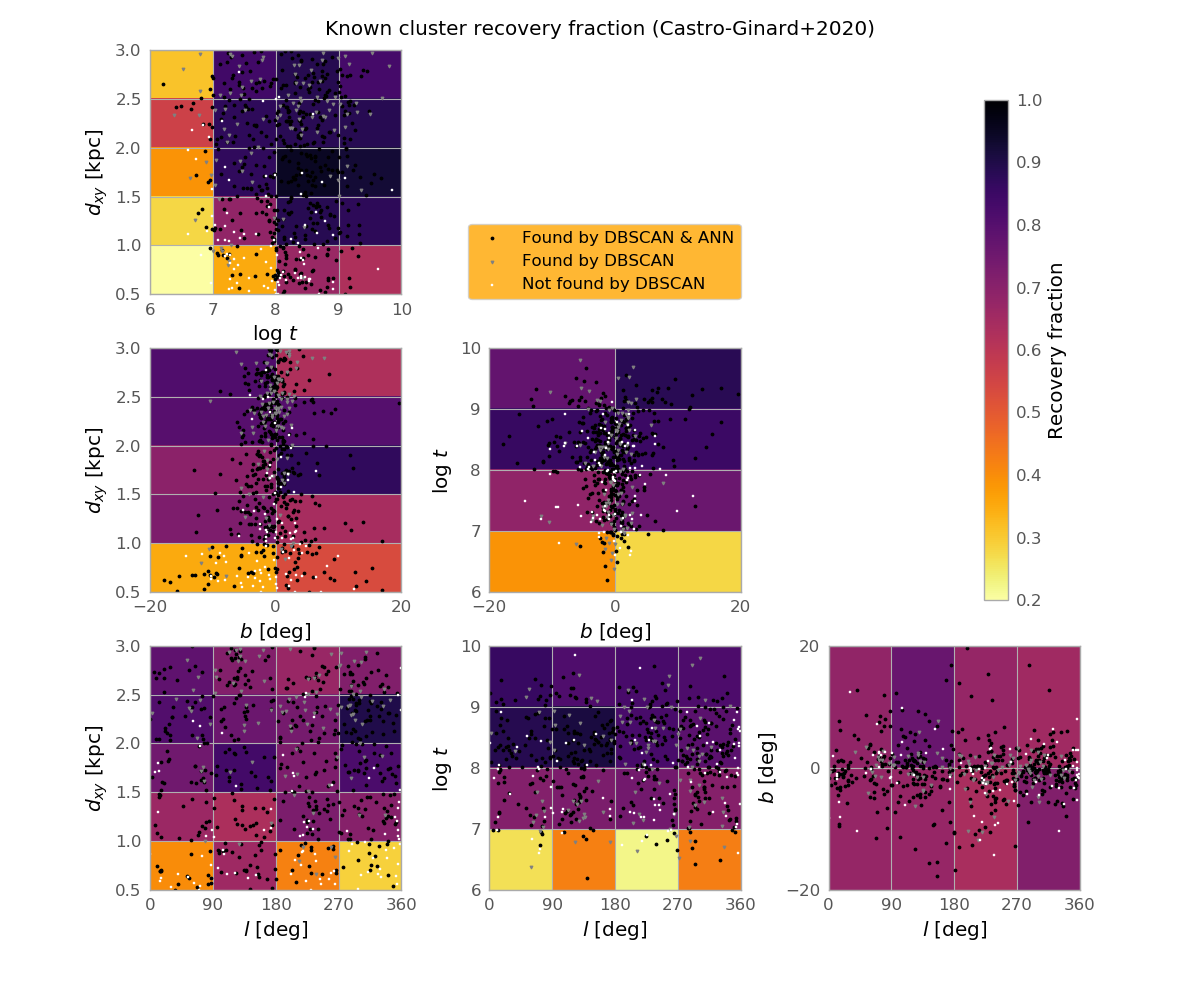

$l$ [deg] $b$ [deg]
$l$ [deg] $\log\ t$
$l$ [deg] $d_{xy}$ [kpc]
$b$ [deg] $\log\ t$
$b$ [deg] $d_{xy}$ [kpc]
$\log\ t$ $d_{xy}$ [kpc]


In [7]:
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(3,3)
gs.update(hspace=0.22, wspace=0.35, top=0.95)
gridlist = [lgrid, bgrid, tgrid, dgrid]
gridname = ["$l$ [deg]", "$b$ [deg]", "$\log\ t$", "$d_{xy}$ [kpc]"]
coordname= ["l", "b", "ageNN", "dxy"]

mask0 = generalmask * (joint["foundness"]==0.0)
mask1 = generalmask * (joint["foundness"]==0.5)
mask2 = generalmask * (joint["foundness"]==1.)

for ii in [0,1,2]:
    for jj in [1,2,3]:
        xx = gridlist[ii]
        yy = gridlist[jj]
        if ii==jj or [ii,jj]==[2,1]:
            pass
        else:
            print(gridname[ii], gridname[jj])
            ax = plt.subplot(gs[2-ii,2-(jj-1)])
            # Find out over which axes we have to marginalise:
            nlist = [0,1,2,3]; nlist.remove(ii); nlist.remove(jj)
            # Integrate over these 2 dimensions
            red_selfunc = np.nansum(selfunc / ( (len(gridlist[nlist[0]])-1) * (len(gridlist[nlist[1]])-1) ), 
                                    axis = tuple(nlist)) 
            plt.imshow(np.fliplr(red_selfunc).T, aspect="auto", cmap="inferno_r", vmax=1, vmin=0.2,
                       extent=[np.min(xx), np.max(xx), np.min(yy), np.max(yy)])
            plt.xlabel(gridname[ii])
            plt.ylabel(gridname[jj])
            # Overplot the data as dots, open dots, and crosses
            plt.scatter(joint[mask2][coordname[ii]], joint[mask2][coordname[jj]], c="k", marker="o", s=3,
                        label="Found by DBSCAN & ANN")
            plt.scatter(joint[mask1][coordname[ii]], joint[mask1][coordname[jj]], c="grey", marker="v", s=3,
                        label="Found by DBSCAN")
            plt.scatter(joint[mask0][coordname[ii]], joint[mask0][coordname[jj]], c="white", marker="+", s=3,
                        label="Not found by DBSCAN")
            if ii == 1 and jj == 2:
                plt.legend(bbox_to_anchor=(1., 1.2), loc='lower right', borderaxespad=0., facecolor="orange")
            if ii == 0:
                ax.set_xticks([0,90,180,270,360])
            if ii == 1:
                ax.set_xticks([-20,0,20])
            if jj == 1:
                ax.set_yticks([-20,0,20])
            plt.axis([np.min(xx), np.max(xx), np.min(yy), np.max(yy)])

plt.suptitle("Known cluster recovery fraction (Castro-Ginard+2020)")
cax = fig.add_axes([0.82, 0.4, 0.02, 0.5])
norm = matplotlib.colors.Normalize(vmin=0.2, vmax=1)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=plt.cm.inferno_r, norm=norm) #, cmap="inferno", norm=norm, spacing='proportional'
cb.set_label('Recovery fraction')
plt.savefig("im/cluster_recovery_experiment_alfred.png", dpi=150)

Now we can define a completeness fraction as a function of $\log t$ out to a limiting distance $d_{xy}^{\rm max}$ by numerically integrating the selection fraction over the $d_{xy}, l$ and $b$ dimensions, and linear interpolation between the $\log t$ bins. Since the method of Castro-Ginard et al. (2020) was optimised for more distant clusters, we extrapolate the recovery fraction from 0.5 kpc inwards. 

We also estimate the uncertainty associated to the completeness estimates.
In order to do this, we can [assume Poissonian distributions of the counts in each age bin](https://online.stat.psu.edu/stat504/node/48/) (for each group: non-detected, half-detected, and detected). This allows us to determine the completeness uncertainties numerically.

In [8]:
dmask = (joint["dxy"] < 2) & (joint["dxy"] > 0.5)
tgrid = np.array([6.5, 7, 7.5, 8, 8.5, 9, 10])

tnumbers = np.zeros(len(tgrid)-1)
tnumbers0= np.zeros(len(tgrid)-1)
tnumbers1= np.zeros(len(tgrid)-1)
tnumbers2= np.zeros(len(tgrid)-1)

for ii in range(len(tnumbers)):
    tnumbers[ii]  = np.sum(dmask & (joint["ageNN"] > tgrid[ii]) & (joint["ageNN"] < tgrid[ii+1]))
    tnumbers0[ii] = np.sum(dmask & (joint["ageNN"] > tgrid[ii]) & (joint["ageNN"] < tgrid[ii+1]) & (joint["foundness"]==0.))
    tnumbers1[ii] = np.sum(dmask & (joint["ageNN"] > tgrid[ii]) & (joint["ageNN"] < tgrid[ii+1]) & (joint["foundness"]==1.))
    tnumbers2[ii] = np.sum(dmask & (joint["ageNN"] > tgrid[ii]) & (joint["ageNN"] < tgrid[ii+1]) & (joint["foundness"]==0.5))

In [9]:
completeness_per_agebin = np.zeros((len(tgrid)-1, 3))

for ii in np.arange(len(tgrid)-1):
    poisson_0, poisson1, poisson2 = np.random.poisson(lam=tnumbers0[ii], size=1000), \
                                    np.random.poisson(lam=tnumbers1[ii], size=1000), \
                                    np.random.poisson(lam=tnumbers2[ii], size=1000)
    poisson_ii =( poisson1 + poisson2 * 0.5 ) / (poisson_0 + poisson1 + poisson2)
    completeness_per_agebin[ii,:] = np.around(np.percentile(poisson_ii, [16,50,84]),2)

def completeness_agebin_castroginard(logt, dmax=2, getquantiles=False):
    """
    Gets you an interpolated completeness value at for a given age value - inferred from the 
    the data behind Castro-Ginard+2020, Fig. 1.
    """
    if dmax==2:
        comp = completeness_per_agebin
    f = interpolate.interp1d(0.5*(tgrid[1:]+tgrid[:-1]), comp[:,1], kind="linear", 
                             fill_value=(comp[0,1],  comp[-1,1]), bounds_error=False)
    fm= interpolate.interp1d(0.5*(tgrid[1:]+tgrid[:-1]), comp[:,0], kind="linear", 
                             fill_value=(comp[0,0],  comp[-1,0]), bounds_error=False)
    fp= interpolate.interp1d(0.5*(tgrid[1:]+tgrid[:-1]), comp[:,2], kind="linear", 
                             fill_value=(comp[0,2],  comp[-1,2]), bounds_error=False)
    if getquantiles:
        return fm(logt), f(logt), fp(logt)
    else:
        return f(logt)

print("DBSCAN rceovery fraction for OCs out to 2kpc at log age [6.5, 7.5, 8.5, 9.5]:\n", 
      completeness_agebin_castroginard((6.5,7.5,8.5,9.5)))

DBSCAN rceovery fraction for OCs out to 2kpc at log age [6.5, 7.5, 8.5, 9.5]:
 [0.52  0.645 0.81  0.88 ]


In [10]:
completeness_per_agebin

array([[0.43, 0.52, 0.62],
       [0.49, 0.55, 0.61],
       [0.69, 0.74, 0.8 ],
       [0.74, 0.78, 0.81],
       [0.8 , 0.84, 0.88],
       [0.82, 0.88, 0.93]])

## II. Completeness of the ANN results of Cantat-Gaudin+2020 (1,867 clusters) with respect to the full catalogue of 2,017 clusters

First read the catalogue and add some interesting columns:

In [11]:
# Cantat-Gaudin+2020
nntable = Table.read("./data/Table1_CDS.fits")
for col in ["X", "Y", "Z", "Rgc"]:
    nntable[col] = nntable[col].astype(float)
mask = nntable["ageNN"]>0
nnfails = nntable[~mask ]
nntable = nntable[ mask ]
# 1st: estimate the position of the clusters not fitted by the ANN:
distpdf = abj2016.distpdf(nnfails["par"]+0.029, np.sqrt( nnfails["sigpar"]**2. + 0.05**2. ) )
nnfails["d"] = distpdf.modedist

nnfails["X"] = np.cos(nnfails["b"] * np.pi / 180.) * np.cos(nnfails["l"] * np.pi / 180.) * nnfails["d"]
nnfails["Y"] = np.cos(nnfails["b"] * np.pi / 180.) * np.sin(nnfails["l"] * np.pi / 180.) * nnfails["d"]
nnfails["Z"] = np.sin(nnfails["b"] * np.pi / 180.) * nnfails["d"]
nnfails["dxy"] = np.sqrt( nnfails["X"]**2. + nnfails["Y"]**2. ) 

# Also Kharchenko+2013
kharchenko = Table.read("./data/Kharchenko2013.fits")

/home/friedel/Desktop/gaiadr2-caf/abj2016.py:62: RuntimeWarning: divide by zero encountered in true_divide
  return 1/np.sqrt(2*np.pi*sigma_pi**2.) * np.exp(-1/(2*sigma_pi**2.) * (pi[np.newaxis, :] - 1./d[:, np.newaxis])**2. )


Plot the Galactic distribution - focussing on the clusters with missing ANN parameters (right hand plot). 
It may take a minute to compute the 2D KDE background distributions.

/home/friedel/Desktop/gaiadr2-caf/abj2016.py:62: RuntimeWarning: divide by zero encountered in true_divide
  return 1/np.sqrt(2*np.pi*sigma_pi**2.) * np.exp(-1/(2*sigma_pi**2.) * (pi[np.newaxis, :] - 1./d[:, np.newaxis])**2. )


<IPython.core.display.Javascript object>


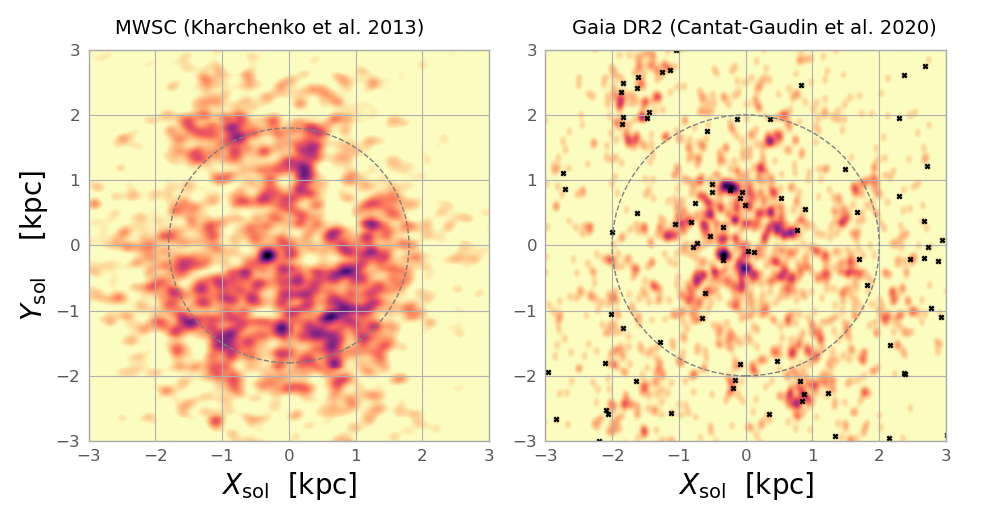

In [12]:
kharchenko["X"] = np.cos(kharchenko["GLAT"] * np.pi / 180.) * np.cos(kharchenko["GLON"] * np.pi / 180.) \
                  * kharchenko["d"]
kharchenko["Y"] = np.cos(kharchenko["GLAT"] * np.pi / 180.) * np.sin(kharchenko["GLON"] * np.pi / 180.) \
                  * kharchenko["d"]
# estimate the position of the clusters not fitted by the ANN:
distpdf = abj2016.distpdf(nnfails["par"]+0.029, np.sqrt( nnfails["sigpar"]**2. + 0.05**2. ) )
nnfails["d"] = distpdf.modedist

nnfails["X"] = np.cos(nnfails["b"] * np.pi / 180.) * np.cos(nnfails["l"] * np.pi / 180.) * nnfails["d"]
nnfails["Y"] = np.cos(nnfails["b"] * np.pi / 180.) * np.sin(nnfails["l"] * np.pi / 180.) * nnfails["d"]
nnfails["Z"] = np.sin(nnfails["b"] * np.pi / 180.) * nnfails["d"]

fig = plt.figure(figsize=(10., 5.2))

# Left: Kharchenko+2013, right: Cantat-Gaudin+2020
subplots = [121,122]
data = [ np.vstack([kharchenko["X"]/1000., kharchenko["Y"]/1000.]),
         np.vstack([nntable["X"]/1000., nntable["Y"]/1000.]) ]
text = ["MWSC (Kharchenko et al. 2013)", "Gaia DR2 (Cantat-Gaudin et al. 2020)"]
circl= [1.8,2]

for ii in [0,1]:
    ax  = plt.subplot(subplots[ii])
    kde = gaussian_kde(data[ii], bw_method=0.025)

    xrange=(-3,3)
    yrange=(-3,3)
    grid=400
    # evaluate on a regular grid
    xgrid = np.linspace(xrange[0], xrange[1], grid)
    ygrid = np.linspace(yrange[0], yrange[1], grid)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

    # Plot the result as an image
    plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[xrange[0], xrange[1],yrange[0], yrange[1]],
           cmap='magma_r', vmin=0.01)#,norm=LogNorm())

    plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
    ax.set_xlabel(r"$X_{\rm sol}$  [kpc]", fontsize=20)
    if ii == 0:
        ax.set_ylabel(r"$Y_{\rm sol}$    [kpc]", fontsize=20)
    else:
        ax.scatter(nnfails["X"], nnfails["Y"], marker="x", s=10, c="k")

    ax.text(-2.6,3.25, text[ii], fontsize=14)
    
    # Overplot the completeness limit considered
    circle1 = plt.Circle((0, 0), circl[ii], color='grey', ls="--", fill=False)
    ax.add_artist(circle1)
plt.tight_layout()

In [13]:
# Join the 2 tables to estimate the parameters of the missing objects
kharchenko["oc"] = kharchenko["Name"]
k13_cg20_match = astropy.table.join(nntable, kharchenko, join_type='inner', keys="oc", uniq_col_name='{col_name}_{table_name}', 
                                    table_names=['1', '2'], metadata_conflicts='warn')
k13_cg20f_match = astropy.table.join(nnfails, kharchenko, join_type='inner', keys="oc", uniq_col_name='{col_name}_{table_name}', 
                                    table_names=['1', '2'], metadata_conflicts='warn')
kharchenko["X"] = np.cos(kharchenko["GLAT"] * np.pi / 180.) * np.cos(kharchenko["GLON"] * np.pi / 180.) \
                  * kharchenko["d"]
kharchenko["Y"] = np.cos(kharchenko["GLAT"] * np.pi / 180.) * np.sin(kharchenko["GLON"] * np.pi / 180.) \
                  * kharchenko["d"]


Now plot the direct comparison between the age scales of Kharchenko+2013 and CG2020 for the objects within a limiting distance `dmax`.

<IPython.core.display.Javascript object>


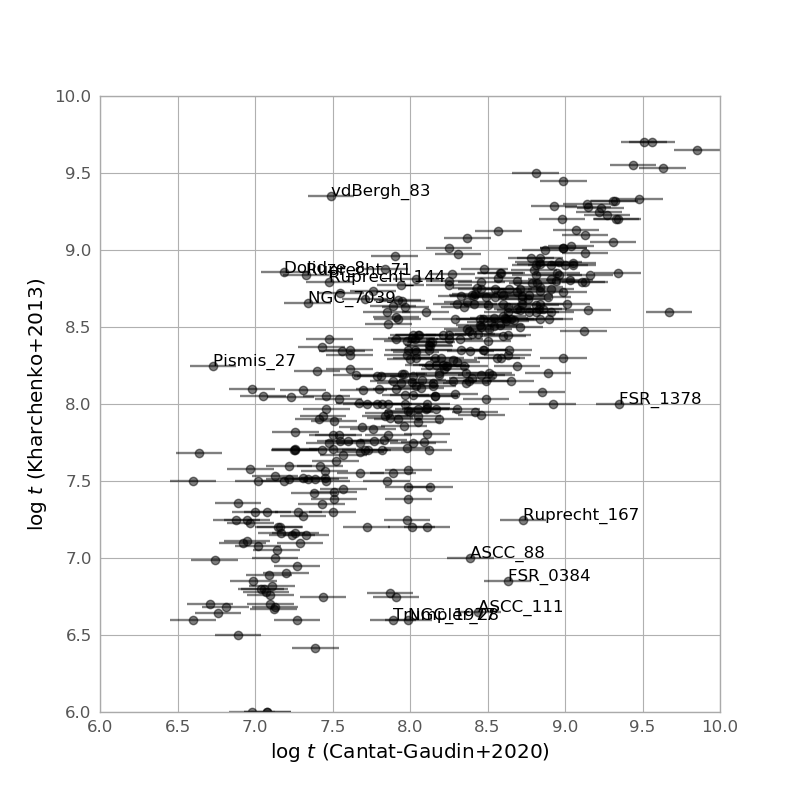

In [14]:
dmax = 2.
distmask = ( np.sqrt(k13_cg20_match["X_1"]**2. + k13_cg20_match["Y_1"]**2.) < dmax*1000 )

plt.figure(figsize=(8, 8))
ax=plt.subplot(111)
plt.plot(np.array([6,6]), np.array([10,10]), ls="dashed", c="grey", lw=1)
plt.errorbar(k13_cg20_match["ageNN"][distmask], k13_cg20_match["logt"][distmask],
             xerr=0.15*np.ones(np.sum(distmask)), fmt="o", c="k",
             alpha=0.5)
ax.set_xlabel(r"log $t$ (Cantat-Gaudin+2020)")
ax.set_ylabel(r"log $t$ (Kharchenko+2013)")
for ii in np.arange(np.sum(distmask)):
    if abs(k13_cg20_match["ageNN"][distmask][ii] - k13_cg20_match["logt"][distmask][ii]) > 1.2:
        if k13_cg20_match["oc"][distmask][ii] in [b"Dolidze_8", b"NGC_7039", b"Trumpler28"]:
            ax.text(k13_cg20_match["ageNN"][distmask][ii]-.5, k13_cg20_match["logt"][distmask][ii]-.15, 
                    k13_cg20_match["Name"][distmask][ii])
        else:
            ax.text(k13_cg20_match["ageNN"][distmask][ii], k13_cg20_match["logt"][distmask][ii], 
                    k13_cg20_match["Name"][distmask][ii])

ax.axis([6,10,6,10])
plt.show()

What does this tell us? 

Well, that the differences in the CAF cannot be explained by a different age scale of the Kharchenko+2013 catalogue: in fact it is surprisingly consistent, except for a few outliers. Especially the number of old clusters in the overlap sample is very similar.

The problem, therefore, must lie in the objects that are not part of both samples: 

1. The CG2020 catalogue has a lot of new clusters within 2 kpc - what ages do they typically sample?
2. The K13 objects that CG2020 do not recover - which ages do they (allegedly) have?

In [15]:
#Do statistics for the dmax-limited sample
dmax = 2

print("OC age statistics in the extended solar vicinity (not completeness-corrected):")
##############################
print("-------------------------------")
distmask_k13 = ( np.sqrt(kharchenko["X"]**2. + kharchenko["Y"]**2.) < dmax*1000 )
print(len(kharchenko[ distmask_k13 ]), "K13 OCs within", dmax, "kpc")
print(len(kharchenko[ distmask_k13 & ( kharchenko["logt"]>9 )]), "out of those have log t_K13 > 9 (", 
      int(100*len(kharchenko[ distmask_k13 & ( kharchenko["logt"]>9 )])/len(kharchenko[ distmask_k13 ])), "% )")
##############################
distmask_nn = ( np.sqrt(nntable["X"]**2. + nntable["Y"]**2.) < dmax*1000 )
print("-------------------------------")
print(len(nntable[ distmask_nn ]), "CG20 OCs within", dmax, "kpc")
print(len(nntable[ distmask_nn & ( nntable["ageNN"]>9 )]), "out of those have log t_CG20 > 9 (", 
      int(1000*len(nntable[ distmask_nn & ( nntable["ageNN"]>9 )])/len(nntable[ distmask_nn ]))/10, "% )")
###############################
print("-------------------------------")
print(len(k13_cg20_match), "overlap between K13 & CG20 NN")

distmask = ( np.sqrt(k13_cg20_match["X_1"]**2. + k13_cg20_match["Y_1"]**2.) < dmax*1000 )
print("-------------------------------")
print(len(k13_cg20_match[ distmask ]), "overlap within", dmax, "kpc")
print(len(k13_cg20_match[ distmask & ( k13_cg20_match["logt"]>9 )]), "out of those have log t_K13 > 9")
print(len(k13_cg20_match[ distmask & ( k13_cg20_match["ageNN"]>9 )]), "out of those have log t_CG20 > 9")
###############################
distmask_nnf = ( nnfails["dxy"] < dmax )
print("-------------------------------")
print(len(nnfails[ distmask_nnf ]), "CG20 (no NN) OCs within", dmax, "kpc")
###############################
print("-------------------------------")
print(len(k13_cg20f_match), "overlap between K13 & CG20 (no NN)")

distmaskf = ( k13_cg20f_match["d_2"]*np.cos( 180*k13_cg20f_match["GLAT"]/np.pi ) < dmax*1000 )
distmaskf = ( k13_cg20f_match["dxy"] < dmax )
print("-------------------------------")
print(len(k13_cg20f_match[ distmaskf ]), "overlap within", dmax, "kpc")
print(len(k13_cg20f_match[ distmaskf & ( k13_cg20f_match["logt"]>9 )]), "out of those have log t_K13 > 9")

OC age statistics in the extended solar vicinity (not completeness-corrected):
-------------------------------
1461 K13 OCs within 2 kpc
241 out of those have log t_K13 > 9 ( 16 % )
-------------------------------
834 CG20 OCs within 2 kpc
54 out of those have log t_CG20 > 9 ( 6.4 % )
-------------------------------
1007 overlap between K13 & CG20 NN
-------------------------------
391 overlap within 2 kpc
29 out of those have log t_K13 > 9
32 out of those have log t_CG20 > 9
-------------------------------
33 CG20 (no NN) OCs within 2 kpc
-------------------------------
85 overlap between K13 & CG20 (no NN)
-------------------------------
16 overlap within 2 kpc
0 out of those have log t_K13 > 9


Now, from the non-converged ANN clusters in the overlap sample, determine the age-dependent completeness of the ANN sample with respect to the full CG2020 sample:

In [16]:
def completeness_agebin_cantat2020_ann(logt, dmax=dmax):
    """
    Gets you an interpolated completeness value at for a given age value - inferred from the 
    the Kharchenko+2013 ages for the clusters that lack ANN parameters
    """
    agebins = np.linspace(6,10,5)
    comp_nn = np.zeros(4)
    if dmax==2:
        comp_nn = [0.7692, 0.9932, 0.9955 , 1.]
    #else:
    for ii in np.arange(len(comp_nn)):
        maskok = distmask_nn  & ( nntable["ageNN"]>agebins[ii] )  & ( nntable["ageNN"]<agebins[ii+1] )
        maskf  = distmaskf    & ( k13_cg20f_match["logt"]>agebins[ii] ) & ( k13_cg20f_match["logt"]<agebins[ii+1] )
        comp_nn[ii] = np.sum(maskok) / ( np.sum(maskok) + np.sum(maskf) )
    f = interpolate.interp1d(0.5*(agebins[1:]+agebins[:-1]), comp_nn, kind="linear", 
                             fill_value=(comp_nn[0],  comp_nn[-1]), bounds_error=False)
    return f(logt)

In [17]:
print("ANN completeness out to 2kpc at log age [6.5, 7.5, 8.5, 9.5]:", completeness_agebin_cantat2020_ann((6.5,7.5,8.5,9.5)))

ANN completeness out to 2kpc at log age [6.5, 7.5, 8.5, 9.5]: [0.76923077 0.99322034 0.9955157  1.        ]
